## Setting up Notebook and Reading in Data

In [5]:
#import the necessary libraries 
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import scipy.stats
import numpy as np
from math import sqrt
import statsmodels.formula.api as smf

In [6]:
#read in the data on london flows
ldn_flows = pd.read_csv("london_flows.csv")

In [7]:
#set up the metric calculations 
def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

## First Look at Data

In [8]:
ldn_flows.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [9]:
ldn_flows.rename(columns = {"population": "Oi_origpop", "jobs": "Dj_destjob", "distance" : "Dist"}, inplace=True)
ldn_flows.head()

,station_origin,station_destination,flows,Oi_origpop,Dj_destjob,Dist
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [10]:
#checking for zeros

zeros_in_data = ldn_flows.eq(0).any()

# Print columns with zeros
print("Columns with zeros:")
print(zeros_in_data[zeros_in_data].index.tolist())

columns_to_check = ['Oi_origpop', 'Dj_destjob', 'Dist']
rows_with_zeros = ldn_flows[ldn_flows[columns_to_check].eq(0).any(axis=1)]

df_with_zeros = pd.DataFrame(rows_with_zeros)

rows_with_zeros.head()
rows_with_zeros

Columns with zeros:
['flows', 'Oi_origpop', 'Dj_destjob', 'Dist']


,station_origin,station_destination,flows,Oi_origpop,Dj_destjob,Dist
3795,Battersea Park,Brockley,0,0,468,13201.698809
3796,Battersea Park,Canada Water,0,0,20443,10440.366798
3797,Battersea Park,Clapham High Street,0,0,1296,1790.459591
3798,Battersea Park,Dalston Junction,0,0,1289,17192.960480
3799,Battersea Park,Denmark Hill,0,0,2612,5032.444704
...,...,...,...,...,...,...
54895,Victoria,Victoria,0,37517,33251,0.000000
55196,Wandsworth Road,Battersea Park,0,617,0,1168.489261
55429,Wapping,Battersea Park,0,1251,0,11326.177642
56180,Waterloo,Waterloo,58,67372,23466,0.000000


In [11]:
#dropping rows where distance = 0 because these are instances where the origin and destination station are the same

ldn_flows.drop(ldn_flows[ldn_flows['Dist']==0].index,axis=0,inplace=True)

In [12]:
ldn_flows.drop(ldn_flows[ldn_flows['station_origin']=='Battersea Park'].index,axis=0,inplace=True)
ldn_flows.drop(ldn_flows[ldn_flows['station_destination']=='Battersea Park'].index,axis=0,inplace=True)

In [13]:
#set zeros to a very small number
ldn_flows["Dj_destjob"] = ldn_flows.apply(lambda x: 0.00000001 if x["Dj_destjob"] == 0 else x["Dj_destjob"], axis = 1)
ldn_flows["Oi_origpop"] = ldn_flows.apply(lambda x: 0.00000001 if x["Oi_origpop"] == 0 else x["Oi_origpop"], axis = 1)

In [14]:
#checking for zeros

zeros_in_data = ldn_flows.eq(0).any()

# Print columns with zeros
print("Columns with zeros:")
print(zeros_in_data[zeros_in_data].index.tolist())

columns_to_check = ['Oi_origpop', 'Dj_destjob', 'Dist']
rows_with_zeros = ldn_flows[ldn_flows[columns_to_check].eq(0).any(axis=1)]

df_with_zeros = pd.DataFrame(rows_with_zeros)

rows_with_zeros.head()
rows_with_zeros

Columns with zeros:
['flows']


,station_origin,station_destination,flows,Oi_origpop,Dj_destjob,Dist


In [15]:
#show the actual flows between boroughs
ldn_flows_mat = pd.pivot_table(ldn_flows, values ="flows", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
ldn_flows_mat.fillna(0, inplace=True)
ldn_flows_mat = ldn_flows_mat.astype(int)
ldn_flows_mat

/tmp/ipykernel_70725/4179333409.py:2: FutureWarning: The provided callable <function sum at 0x7f09800b3600> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  ldn_flows_mat = pd.pivot_table(ldn_flows, values ="flows", index="station_origin", columns = "station_destination",
/tmp/ipykernel_70725/4179333409.py:2: FutureWarning: The provided callable <function sum at 0x7f09800b3600> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  ldn_flows_mat = pd.pivot_table(ldn_flows, values ="flows", index="station_origin", columns = "station_destination",
/tmp/ipykernel_70725/4179333409.py:2: FutureWarning: The provided callable <function sum at 0x7f09800b3600> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly.

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,32,599
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1224
Acton Town,0,0,0,3,17,0,35,0,0,11,...,77,3,6,9,0,0,0,0,0,3745
Aldgate,0,0,0,0,0,0,0,0,0,17,...,0,0,4,8,0,0,0,0,0,2886
Aldgate East,0,0,2,0,0,0,0,0,0,20,...,24,0,0,12,0,1,0,1,0,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,2,5,47,0,0,0,0,22,...,2,0,1,0,0,0,0,0,0,4868
Woodgrange Park,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,530
Woodside Park,0,0,1,26,11,0,0,0,0,59,...,0,0,0,0,0,0,0,0,0,3093


## Using Function Given In Class to Explore RSquared and RMSE Values for All Models Using All Cost Function

In [ ]:
#set out all the fomrulas
formula1 = "flows ~ np.log(Oi_origpop) + np.log(Dj_destjob) + np.log(Dist)"
formula2 = "flows ~ station_origin + np.log(Dj_destjob) + np.log(Dist)"
formula3 = "flows ~ np.log(Oi_origpop) + station_destination + np.log(Dist) -1"
formula4 = "flows ~ station_origin + station_destination + np.log(Dist) -1"
formula5 = "flows ~ np.log(Oi_origpop) + np.log(Dj_destjob) + Dist"
formula6 = "flows ~ station_origin + np.log(Dj_destjob) + Dist -1"
formula7 = "flows ~ np.log(Oi_origpop) + station_destination + Dist -1"
formula8 = "flows ~ station_origin + station_destination + Dist -1"

#create a list of all the formulas
formulas = [formula1, formula2, formula3, formula4, 
            formula5, formula6, formula7, formula8]

#list the models name
models = ["uncosim_pow", "prodsim_pow", "attrsim_pow", "doublesim_pow",
         "uncosim_exp", "prodsim_exp", "attrsim_exp", "doublesim_exp"]

#create a set of tuples to store whether a paramater
#will be in the model or not
model_params = [(True, True, True),
               (False, True, True),
               (True, False, True),
               (False, False, True),
               (True, True, True),
               (False, True, True),
               (True, False, True),
               (False, False, True)]

#create an ampty dictionary to store the results
results = {"Model":models,
          "R2": [],
          "RMSE": [],
          "Alpha":[],
          "Gamma":[],
          "Beta":[]}


In [ ]:
#loop over each formula
for i, formula in enumerate(formulas):
    
    #run the specified model
    sim = smf.glm(formula = formula, 
                 data = ldn_flows,
                 family = sm.families.Poisson()).fit()
    #clauclate the estimates
    ldn_flows[models[i]] = sim.mu
    
    #if the alpha paramater is true
    if model_params[i][0] == True:
        
        #if there are three params then it will be 
        #in the third position
        if sum(model_params[i]) == 3:
            results["Alpha"].append(sim.params[-3])
            
        #otherwise it will be in the second paramater
        else:
            results["Alpha"].append(sim.params[-2])
            
    #if not then just append nan
    else:
        results["Alpha"].append(np.nan) 
    
    #if the gamma paramater is True
    #then it will always be the second paramater
    if model_params[i][1] == True:
        results["Gamma"].append(sim.params[-2])
    #otherwise add nan
    else:
        results["Gamma"].append(np.nan)
    
    #add the beta to the results (always will be there)
    results["Beta"].append(sim.params[-1])
        
    #add the metrics to the results dictionary
    results["R2"].append(CalcRSquared(ldn_flows["flows"],ldn_flows[models[i]]))
    results["RMSE"].append(CalcRMSE(ldn_flows["flows"],ldn_flows[models[i]]))

#create a dataframe from the results
results = pd.DataFrame(results)
#print the results
results

## Scenario A Production Constrained Model

50% reduction in Canary Wharf jobs.

In [16]:
data_scenario_a = ldn_flows.copy()

In [17]:
#create the formula 
formula = "flows ~ station_origin + np.log(Dj_destjob) + Dist -1"

#run a production constrained sim
prodSim = smf.glm(formula = formula, data=data_scenario_a, family=sm.families.Poisson()).fit()

print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.0994e+05
Date:                Thu, 18 Apr 2024   Deviance:                   1.6477e+06
Time:                        12:53:43   Pearson chi2:                 2.40e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [18]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i = pd.DataFrame(data_scenario_a.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
data_scenario_a = data_scenario_a.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(data_scenario_a.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
data_scenario_a = data_scenario_a.merge(D_j, on = "station_destination", how = "left" )

/tmp/ipykernel_70725/1442584557.py:3: FutureWarning: The provided callable <function sum at 0x7f09800b3600> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  O_i = pd.DataFrame(data_scenario_a.groupby(["station_origin"])["flows"].agg(np.sum))
/tmp/ipykernel_70725/1442584557.py:7: FutureWarning: The provided callable <function sum at 0x7f09800b3600> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  D_j = pd.DataFrame(data_scenario_a.groupby(["station_destination"])["flows"].agg(np.sum))


In [19]:
#pullout the parameter values

# this didnt work

#coefs = pd.DataFrame(prodSim.params)
#coefs.reset_index(inplace=True)
#coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
#to_repl = ["(station_origin)", "\[", "\]"]
#for x in to_repl:
 #   coefs["coef"] = coefs["coef"].str.replace(x, "",regex=True)

#alpha_i = prodSim.params[0:-2]
#gamma = prodSim.params[-2]
#beta = -prodSim.params[-1]

In [20]:
# Assuming prodSim.params is already defined
coefs = pd.DataFrame(prodSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns={0: "alpha_i", "index": "coef"}, inplace=True)

# Using regex to replace multiple patterns at once
coefs["coef"] = coefs["coef"].str.replace(r"(station_origin|\[|\])", "", regex=True)

# If you only want to remove the exact substrings without treating them as regex:
# coefs["coef"] = coefs["coef"].str.replace("(station_origin)", "", regex=False)
# coefs["coef"] = coefs["coef"].str.replace("[", "", regex=False)
# coefs["coef"] = coefs["coef"].str.replace("]", "", regex=False)

alpha_i = prodSim.params[0:-2]
gamma = prodSim.params[-2]
beta = -prodSim.params[-1]

print(coefs)



/tmp/ipykernel_70725/3708968262.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma = prodSim.params[-2]
/tmp/ipykernel_70725/3708968262.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = -prodSim.params[-1]


                   coef   alpha_i
0            Abbey Road -2.914322
1         Acton Central -1.162092
2            Acton Town -1.613081
3               Aldgate -2.943047
4          Aldgate East -2.854752
..                  ...       ...
395     Woodgrange Park -0.896422
396       Woodside Park -1.149110
397    Woolwich Arsenal  0.518041
398  np.log(Dj_destjob)  0.755222
399                Dist -0.000153

[400 rows x 2 columns]


In [21]:
#join back into the dataframes

data_scenario_a = data_scenario_a.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
data_scenario_a.drop(columns = ["coef"], inplace = True)

In [22]:
data_scenario_a.head()

,station_origin,station_destination,flows,Oi_origpop,Dj_destjob,Dist,O_i,D_j,alpha_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,-2.914322
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,-2.914322
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,-2.914322
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,-2.914322
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,-2.914322


In [23]:
#alpha_i = prodSim.params[0:-2]
#gamma = prodSim.params[-2]
#beta = -prodSim.params[-1]

In [24]:
beta

0.00015316619346377426

In [25]:
data_scenario_a["prodsimest1"] = np.exp(data_scenario_a["alpha_i"]+gamma*np.log(data_scenario_a["Dj_destjob"]) - beta * np.log(data_scenario_a["Dist"]))
data_scenario_a.head()

,station_origin,station_destination,flows,Oi_origpop,Dj_destjob,Dist,O_i,D_j,alpha_i,prodsimest1
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,-2.914322,269.552327
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,-2.914322,5.390191
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,-2.914322,7.338952
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,-2.914322,216.540376
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,-2.914322,78.870596


## Introducing Scenario A

In [26]:
#accounting for 50% reduction in jobs in Canary Wharf

def scenario_a(row):
    if row["station_destination"] == "Canary Wharf":
        val = row["Dj_destjob"] / 2
    else:
        val = row["Dj_destjob"]
    return val
        
data_scenario_a["job_scenario_a"] = data_scenario_a.apply(scenario_a, axis =1)
data_scenario_a.head(10)

,station_origin,station_destination,flows,Oi_origpop,Dj_destjob,Dist,O_i,D_j,alpha_i,prodsimest1,job_scenario_a
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,-2.914322,269.552327,78549.0
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,-2.914322,5.390191,442.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,-2.914322,7.338952,665.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,-2.914322,216.540376,29386.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,-2.914322,78.870596,15428.0
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,599,1208,-2.914322,11.518175,1208.0
6,Abbey Road,Custom House,0,599,845,3824.855630,599,845,-2.914322,8.794329,845.0
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,599,1748,-2.914322,15.225147,1748.0
8,Abbey Road,Cyprus,7,599,850,6532.099618,599,850,-2.914322,8.832877,850.0
9,Abbey Road,Devons Road,1,599,611,3958.324171,599,611,-2.914322,6.884201,611.0


In [27]:
# checking to see if worked
canary_wharf = data_scenario_a[data_scenario_a["station_destination"] == "Canary Wharf"]

# Displaying the filtered rows
canary_wharf.head()


,station_origin,station_destination,flows,Oi_origpop,Dj_destjob,Dist,O_i,D_j,alpha_i,prodsimest1,job_scenario_a
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,-2.914322,216.540376,29386.0
126,Acton Town,Canary Wharf,57,3745,58772,20398.165882,3745,58772,-1.613081,795.368142,29386.0
348,Aldgate,Canary Wharf,1,2886,58772,6564.419680,2886,58772,-2.943047,210.400438,29386.0
595,Aldgate East,Canary Wharf,3,3172,58772,5127.998899,3172,58772,-2.854752,229.831307,29386.0
817,All Saints,Canary Wharf,67,740,58772,1340.088733,740,58772,-2.878322,224.523664,29386.0


In [28]:
# Using production constraint on the new scenario A figures and calculated gamma and beta values 
# that were in the table above
data_scenario_a["prodsimest2"] = np.exp(data_scenario_a["alpha_i"] + gamma * np.log(data_scenario_a["job_scenario_a"]) - beta * np.log(data_scenario_a["Dist"]))

#data_scenario_a["prodsimest2"] = round(data_scenario_a["prodsimest"], 0)


In [29]:
#calculate some new wj^alpha and d_ij^beta values
Dj2_gamma = data_scenario_a["Dj_destjob"]**gamma
dist_beta = np.exp(data_scenario_a["Dist"]*(-beta))                                      #data_scenario_a["Dist"]**beta
#calcualte the first stage of the Ai values
data_scenario_a["Ai1"] = Dj2_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(data_scenario_a.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)
#and write the A_i values back into the dataframe
data_scenario_a = data_scenario_a.merge(A_i, left_on="station_origin", right_index=True, how="left")

/tmp/ipykernel_70725/2463724296.py:7: FutureWarning: The provided callable <function sum at 0x7f09800b3600> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  A_i = pd.DataFrame(data_scenario_a.groupby(["station_origin"])["Ai1"].agg(np.sum))


In [30]:
#to check everything works, recreate the original estimates
data_scenario_a["prodsimest3"] = data_scenario_a["A_i"]*data_scenario_a["O_i"]*Dj2_gamma*dist_beta
#round
#data_scenario_a["prodsimest3"] = round(data_scenario_a["prodsimest3"])

In [31]:
#calculate some new wj^alpha and d_ij^beta values
Dj3_gamma = data_scenario_a["job_scenario_a"]**gamma
#calcualte the first stage of the Ai values
data_scenario_a["Ai1"] = Dj3_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(data_scenario_a.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i2"}, inplace=True)
#and write the A_i values back into the dataframe
data_scenario_a = data_scenario_a.merge(A_i, left_on="station_origin", right_index=True, how="left")

/tmp/ipykernel_70725/569376925.py:6: FutureWarning: The provided callable <function sum at 0x7f09800b3600> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  A_i = pd.DataFrame(data_scenario_a.groupby(["station_origin"])["Ai1"].agg(np.sum))


In [32]:
#new job scenario
data_scenario_a["prodsimest4"] = data_scenario_a["A_i2"]*data_scenario_a["O_i"]*Dj3_gamma*dist_beta
#round
#data_scenario_a["prodsimest4"] = round(data_scenario_a["prodsimest4"])

In [33]:
data_scenario_a_mat4 = data_scenario_a.pivot_table(values ="prodsimest4", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
data_scenario_a_mat4.fillna(0, inplace=True)
data_scenario_a_mat4

/tmp/ipykernel_70725/2805047709.py:1: FutureWarning: The provided callable <function sum at 0x7f09800b3600> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  data_scenario_a_mat4 = data_scenario_a.pivot_table(values ="prodsimest4", index="station_origin", columns = "station_destination",
/tmp/ipykernel_70725/2805047709.py:1: FutureWarning: The provided callable <function sum at 0x7f09800b3600> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  data_scenario_a_mat4 = data_scenario_a.pivot_table(values ="prodsimest4", index="station_origin", columns = "station_destination",
/tmp/ipykernel_70725/2805047709.py:1: FutureWarning: The provided callable <function sum at 0x7f09800b3600> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided c

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.019256,599.0
Acton Central,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.330341,0.000000,0.000000,1224.0
Acton Town,0.000000,0.000000,0.000000,12.960954,12.670626,0.000000,13.729315,0.042496,0.000000,16.010045,...,13.386988,2.908541,1.925342,19.684852,0.000000,0.226648,0.000000,0.541201,0.000000,3745.0
Aldgate,0.000000,0.000000,1.330659,0.000000,37.666273,0.000000,0.000000,0.003439,0.000000,27.775512,...,2.120582,0.000000,2.522850,2.069359,0.000000,0.672034,0.000000,0.551710,0.000000,2886.0
Aldgate East,0.000000,0.000000,1.404278,40.660974,0.000000,0.000000,0.288023,0.003628,0.000000,29.304406,...,2.237903,0.486221,2.661720,2.183266,0.000000,0.917124,0.000000,0.582078,0.000000,3172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0.000000,0.000000,1.449927,41.875048,52.937915,0.000000,0.000000,0.000000,0.000000,30.857981,...,2.310652,0.000000,5.834715,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4868.0
Woodgrange Park,0.000000,1.012373,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,530.0
Woodside Park,0.000000,0.000000,1.954437,19.406346,18.966601,0.000000,0.400863,0.000000,0.000000,31.688044,...,3.114654,0.000000,3.810753,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3093.0


## Understanding and Visualising the Impact

In [34]:
# see what impact the reduction of jobs had on flows

#here positive values are flows lost and negative values are flows gained
data_scenario_a["Diff"] = data_scenario_a["flows"]-data_scenario_a["prodsimest4"]
data_scenario_a.head()

,station_origin,station_destination,flows,Oi_origpop,Dj_destjob,Dist,O_i,D_j,alpha_i,prodsimest1,job_scenario_a,prodsimest2,Ai1,A_i,prodsimest3,A_i2,prodsimest4,Diff
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,-2.914322,269.552327,78549.0,269.552327,1432.231104,0.000091,77.685360,0.000097,83.325388,-83.325388
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,-2.914322,5.390191,442.0,5.390191,27.026714,0.000091,1.465951,0.000097,1.572380,-0.572380
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,-2.914322,7.338952,665.0,7.338952,75.982904,0.000091,4.121373,0.000097,4.420589,-1.420589
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,-2.914322,216.540376,29386.0,128.290511,1086.638601,0.000091,99.484532,0.000097,63.219255,-62.219255
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,-2.914322,78.870596,15428.0,78.870596,1034.750388,0.000091,56.125688,0.000097,60.200464,-23.200464


In [35]:
#checking the number of flows is conserved

# adding all flows from station pairs together
original_flows = data_scenario_a['flows'].sum()
scenario_a_flows = data_scenario_a['prodsimest4'].sum()

print(original_flows)
print(scenario_a_flows)

1542283
1542282.9999999998


In [36]:
data_scenario_a['flows'].describe()

count    61413.000000
mean        25.113298
std        131.479668
min          0.000000
25%          0.000000
50%          3.000000
75%         13.000000
max      15946.000000
Name: flows, dtype: float64

In [37]:
data_scenario_a['prodsimest4'].describe()

count    61413.000000
mean        25.113298
std         80.342254
min          0.000293
25%          1.289844
50%          5.638347
75%         19.760771
max       3717.399677
Name: prodsimest4, dtype: float64

In [38]:
# sorting dataframe to see which stations affected the most:

data_scenario_a_sorted = data_scenario_a.sort_values(by="prodsimest4", ascending=False)
data_scenario_a_sorted.head(20)

,station_origin,station_destination,flows,Oi_origpop,Dj_destjob,Dist,O_i,D_j,alpha_i,prodsimest1,job_scenario_a,prodsimest2,Ai1,A_i,prodsimest3,A_i2,prodsimest4,Diff
55890,Waterloo,Bank and Monument,15946,67372,78549,2542.954444,67314,78549,0.089300,5434.715403,78549.0,5434.715403,3371.013816,0.000016,3685.895439,0.000016,3717.399677,12228.600323
27821,Ilford,Stratford,3080,5298,55954,5635.299025,5298,55954,0.622375,7167.770210,55954.0,7167.770210,1624.833306,0.000352,3027.630146,0.000352,3027.630146,52.369854
49857,Stratford,Bank and Monument,1138,59311,78549,7539.963954,59311,78549,0.553267,8641.772631,78549.0,8641.772631,1568.062231,0.000029,2726.742336,0.000030,2784.166292,-1646.166292
56015,Waterloo,Liverpool Street,1571,67372,61122,3384.457128,67314,61122,0.089300,4496.572569,61122.0,4496.572569,2451.930950,0.000016,2680.962345,0.000016,2703.877177,-1132.877177
50041,Stratford,Liverpool Street,6946,59311,61122,6698.461270,59311,61122,0.553267,7150.468921,61122.0,7150.468921,1475.921377,0.000029,2566.516318,0.000030,2620.565987,4325.434013
32584,London Bridge,Bank and Monument,445,32597,78549,886.728371,32593,78549,-0.595690,2740.056561,78549.0,2740.056561,4344.416155,0.000017,2394.564495,0.000017,2422.529757,-1977.529757
32282,Liverpool Street,Bank and Monument,812,31473,78549,841.502684,31473,78549,-0.614649,2688.619523,78549.0,2688.619523,4374.614599,0.000017,2365.926532,0.000017,2392.261232,-1580.261232
56046,Waterloo,Oxford Circus,2425,67372,44368,2645.397667,67314,44368,0.089300,3530.414916,44368.0,3530.414916,2155.746342,0.000016,2357.111553,0.000016,2377.258354,47.741646
56116,Waterloo,Victoria,285,67372,33251,2188.414963,67314,33251,0.089300,2839.457843,33251.0,2839.457843,1859.485763,0.000016,2033.177692,0.000016,2050.555753,-1765.555753
56016,Waterloo,London Bridge,1862,67372,29930,1754.776015,67314,29926,0.089300,2622.635909,29930.0,2622.635909,1835.380342,0.000016,2006.820618,0.000016,2023.973399,-161.973399


### Filtering for Canary Wharf

In [39]:
# Filter for rows where the destination is Canary Wharf
canary_wharf_diff = data_scenario_a[data_scenario_a['station_destination'] == 'Canary Wharf']['Diff']

# Sum up the 'Diff' values for these rows
total_diff_canary_wharf = canary_wharf_diff.sum()

print(f"Total 'Diff' for Canary Wharf: {total_diff_canary_wharf}")


Total 'Diff' for Canary Wharf: 29277.829110667393


In [40]:
# Filter for rows where the destination is Canary Wharf
canary_wharf_diff = data_scenario_a[data_scenario_a['station_destination'] == 'Canary Wharf']['Diff']

# Sum up the 'Diff' values for these rows
total_diff_canary_wharf = canary_wharf_diff.sum()

print(f"Total 'Diff' for Canary Wharf: {total_diff_canary_wharf}")

Total 'Diff' for Canary Wharf: 29277.829110667393


In [41]:
# sorting dataframe to see which stations had more flows added:
# here negative values are flows lost and positive are flows gained

data_scenario_a["Diff_more_flow"] = data_scenario_a["prodsimest4"]-data_scenario_a["flows"]

data_scenario_a_moreflows = data_scenario_a.sort_values(by="Diff_more_flow", ascending=False)
data_scenario_a_moreflows.head(10)

,station_origin,station_destination,flows,Oi_origpop,Dj_destjob,Dist,O_i,D_j,alpha_i,prodsimest1,job_scenario_a,prodsimest2,Ai1,A_i,prodsimest3,A_i2,prodsimest4,Diff,Diff_more_flow
32584,London Bridge,Bank and Monument,445,32597,78549,886.728371,32593,78549,-0.595690,2740.056561,78549.0,2740.056561,4344.416155,0.000017,2394.564495,0.000017,2422.529757,-1977.529757,1977.529757
56116,Waterloo,Victoria,285,67372,33251,2188.414963,67314,33251,0.089300,2839.457843,33251.0,2839.457843,1859.485763,0.000016,2033.177692,0.000016,2050.555753,-1765.555753,1765.555753
49857,Stratford,Bank and Monument,1138,59311,78549,7539.963954,59311,78549,0.553267,8641.772631,78549.0,8641.772631,1568.062231,0.000029,2726.742336,0.000030,2784.166292,-1646.166292,1646.166292
32709,London Bridge,Liverpool Street,163,32597,61122,1728.231055,32593,61122,-0.595690,2266.934408,61122.0,2266.934408,3159.942085,0.000017,1741.703569,0.000017,1762.044302,-1599.044302,1599.044302
32282,Liverpool Street,Bank and Monument,812,31473,78549,841.502684,31473,78549,-0.614649,2688.619523,78549.0,2688.619523,4374.614599,0.000017,2365.926532,0.000017,2392.261232,-1580.261232,1580.261232
8488,Canada Water,Bank and Monument,117,27026,78549,3964.071830,27026,78549,-0.503019,3005.429240,78549.0,3005.429240,2711.620412,0.000022,1639.723439,0.000023,1680.854662,-1563.854662,1563.854662
55988,Waterloo,Holborn,197,67372,22346,2570.305840,67314,22346,0.089300,2103.147665,22346.0,2103.147665,1299.076750,0.000016,1420.421668,0.000016,1432.562354,-1235.562354,1235.562354
8635,Canada Water,Liverpool Street,0,27026,61122,4768.132939,27026,61122,-0.503019,2486.669332,61122.0,2486.669332,1983.659756,0.000022,1199.523864,0.000023,1229.613014,-1229.613014,1229.613014
50056,Stratford,Moorgate,26,59311,24574,7132.548719,59311,24574,0.553267,3593.128701,24574.0,3593.128701,693.953684,0.000029,1206.733287,0.000030,1232.146542,-1206.146542,1206.146542
56015,Waterloo,Liverpool Street,1571,67372,61122,3384.457128,67314,61122,0.089300,4496.572569,61122.0,4496.572569,2451.930950,0.000016,2680.962345,0.000016,2703.877177,-1132.877177,1132.877177


In [42]:
total_scenario3 = data_scenario_a.groupby(by="station_destination")['Diff_more_flow'].sum()

total_scenario3_sorted = total_scenario3.sort_values(ascending=False)

print(total_scenario3_sorted)

station_destination
Stratford               11190.080618
Whitechapel              6825.574845
Canada Water             4910.606834
Highbury & Islington     4595.712153
Embankment               3009.841159
                            ...     
Oxford Circus           -4302.094094
Victoria                -4316.375253
Hammersmith             -5186.431245
Bank and Monument       -8528.005648
Canary Wharf           -29277.829111
Name: Diff_more_flow, Length: 398, dtype: float64


In [43]:
total_scenario3 = data_scenario_a.groupby(by="station_destination")['Diff'].sum()

total_scenario3_sorted = total_scenario3.sort_values(ascending=False)

print(total_scenario3_sorted)

station_destination
Canary Wharf            29277.829111
Bank and Monument        8528.005648
Hammersmith              5186.431245
Victoria                 4316.375253
Oxford Circus            4302.094094
                            ...     
Embankment              -3009.841159
Highbury & Islington    -4595.712153
Canada Water            -4910.606834
Whitechapel             -6825.574845
Stratford              -11190.080618
Name: Diff, Length: 398, dtype: float64


In [44]:
data_scenario_a.head()

,station_origin,station_destination,flows,Oi_origpop,Dj_destjob,Dist,O_i,D_j,alpha_i,prodsimest1,job_scenario_a,prodsimest2,Ai1,A_i,prodsimest3,A_i2,prodsimest4,Diff,Diff_more_flow
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,-2.914322,269.552327,78549.0,269.552327,1432.231104,0.000091,77.685360,0.000097,83.325388,-83.325388,83.325388
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,-2.914322,5.390191,442.0,5.390191,27.026714,0.000091,1.465951,0.000097,1.572380,-0.572380,0.572380
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,-2.914322,7.338952,665.0,7.338952,75.982904,0.000091,4.121373,0.000097,4.420589,-1.420589,1.420589
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,-2.914322,216.540376,29386.0,128.290511,1086.638601,0.000091,99.484532,0.000097,63.219255,-62.219255,62.219255
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,-2.914322,78.870596,15428.0,78.870596,1034.750388,0.000091,56.125688,0.000097,60.200464,-23.200464,23.200464


<Figure size 2800x2400 with 0 Axes>

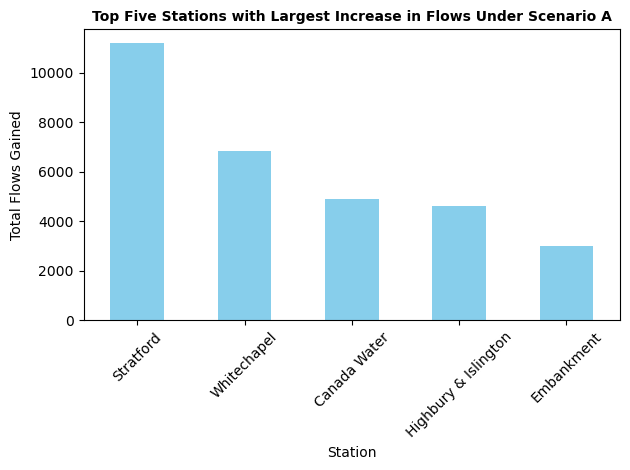

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Example DataFrame
data = {
    'Category': ['Stratford', 'Whitechapel', 'Canada Water', 'Highbury & Islington', 'Embankment'],
    'Value': [11190, 6825, 4910, 4595, 3009]
}
df = pd.DataFrame(data)

# Plotting directly from the DataFrame
plt.figure(figsize=(28, 24))  # Adjusting the figure size
ax = df.set_index('Category').plot(kind='bar', legend=False, color='skyblue', fontsize=10)  # Adjust font size here
plt.title('Top Five Stations with Largest Increase in Flows Under Scenario A', fontsize=10, fontweight='bold')  # Make title bold and increase font size
plt.xlabel('Station', fontsize=10)  # Increase font size for x-axis label
plt.ylabel('Total Flows Gained', fontsize=10)  # Increase font size for y-axis label
plt.xticks(rotation=45)  # Rotates the category labels to prevent overlap and improve readability

plt.tight_layout()  # Adjust layout
plt.savefig('scenario_a.jpg', bbox_inches='tight')  # Save the figure ensuring all content is included
plt.show()



The 'Diff' column shows that the flows from Waterloo to Canary Wharf are the most affected with a decrease in 767 passenger flows in total. 

## Scenario B

Assume that there is a significant increase in the cost of transport. Select 2 values forthe parameter in the cost function reflecting scenario B. Recompute the distribution of flows.

In [46]:
data_scenario_b = data_scenario_a.copy()

## Doubly Constrained Model for 2 Times Increase

### Running the model

In [47]:
# Run a doubly constrained SIM with a negative exponential cost function.
doubsim_form = "flows ~ station_origin + station_destination + Dist -1"
doubsim1 = smf.glm(formula=doubsim_form, data = data_scenario_b, family = sm.families.Poisson()).fit()
print(doubsim1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    60617
Model Family:                 Poisson   Df Model:                          795
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -8.5105e+05
Date:                Thu, 18 Apr 2024   Deviance:                   1.5299e+06
Time:                        12:55:10   Pearson chi2:                 2.02e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [48]:
beta

0.00015316619346377426

In [49]:
data_scenario_b["doubsimfitted1"] = np.round(doubsim1.mu,0)

In [50]:
CalcRSquared(data_scenario_b["flows"],data_scenario_b["doubsimfitted1"])

0.49784274146323315

In [51]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take data_scenario_b ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i = pd.DataFrame(data_scenario_b.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
data_scenario_b = data_scenario_b.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(data_scenario_b.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
data_scenario_b = data_scenario_b.merge(D_j, on = "station_destination", how = "left" )

/tmp/ipykernel_70725/971822036.py:3: FutureWarning: The provided callable <function sum at 0x7f09800b3600> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  O_i = pd.DataFrame(data_scenario_b.groupby(["station_origin"])["flows"].agg(np.sum))
/tmp/ipykernel_70725/971822036.py:7: FutureWarning: The provided callable <function sum at 0x7f09800b3600> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  D_j = pd.DataFrame(data_scenario_b.groupby(["station_destination"])["flows"].agg(np.sum))


In [52]:
# Here is the entropy maximising approach for a known beta.
# Plug in the required values in this function to solve.

def balance_doubly_constrained(pd, orig_field, dest_field, Oi_field, Dj_field, cij_field, beta, 
                               cost_function, Ai_name = "Ai_new", Bj_name = "Bj_new", converge=0.001):
    # Define some variables
    Oi = pd[[orig_field, Oi_field]]
    Dj = pd[[dest_field,Dj_field]]    
    if cost_function.lower() in ['power','pow']:
        beta_cij = np.exp(beta * np.log(pd[cij_field]))
    elif cost_function.lower() in ['exponential','exp']:
        beta_cij = np.exp(beta * pd[cij_field])
    else:
        return "Cost function not specified properly, use 'exp' or 'pow'"
    
    # Create some helper variables
    cnvg = 1
    iteration = 0
    # Now iteratively rebalance the Ai and Bj terms until convergence
    while cnvg > converge:
        if iteration == 0:
            # This first condition sets starting values for Ai and Bj
            # NB sets starting value of Ai assuming Bj is a vector of 1s.
            # We've already established beta_cij with the appropriate cost function, so...
            Oi = Oi.assign(Ai = Dj[Dj_field] * beta_cij)
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Now set up Bjs using starting values of Ai
            Dj = Dj.assign(Bj = Oi['Ai_old'] * Oi[Oi_field] * beta_cij)
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Increment loop
            iteration += 1
        else:
            # This bit is the iterated bit of the loop which refines the values of Ai and Bj
            # First Ai
            Oi['Ai'] = Dj['Bj_old'] * Dj[Dj_field] * beta_cij
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Drop temporary Ai
            Oi.drop('Ai', axis=1, inplace=True)
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True)
            # Calculate the difference between old and new Ais
            Oi['diff'] = np.absolute((Oi['Ai_old'] - Oi['Ai'])/Oi['Ai_old'])
            # Set new Ais to Ai_old
            Oi['Ai_old'] = Oi['Ai']
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Then Bj
            Dj['Bj'] = Oi['Ai_old'] * Oi[Oi_field] * beta_cij
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Drop temporary Bj
            Dj.drop('Bj', axis=1, inplace=True)
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True)
            # Calculate the difference between old and new Bjs
            Dj['diff'] = np.absolute((Dj['Bj_old'] - Dj['Bj'])/Dj['Bj_old'])
            # Set new Bjs to Bj_old
            Dj['Bj_old'] = Dj['Bj']
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Assign higher sum difference from Ai or Bj to cnvg
            cnvg = np.maximum(Oi['diff'].sum(),Dj['diff'].sum())
            
            # Print and increment loop
            print("Iteration:", iteration)
            iteration += 1

    # When the while loop finishes add the computed Ai_old and Bj_old to the dataframe and return
    pd[Ai_name] = Oi['Ai_old']
    pd[Bj_name] = Dj['Bj_old']
    return pd

### Increase beta by x2

In [53]:
# Use the beta we got from the negative exponential model
beta1 = -doubsim1.params[-1] * 2
# Get the balancing factors. NB Setting of new field names for Ai and Bj.
data_scenario_b = balance_doubly_constrained(data_scenario_b,'station_origin','station_destination','O_i_x','D_j_x','Dist',-beta1,'exponential','Ai_exp','Bj_exp')

# Now predict the model again using the new Ai and Dj fields.
data_scenario_b['SIM_est_exp'] = np.round(data_scenario_b['O_i_x'] * data_scenario_b['Ai_exp'] * data_scenario_b['D_j_x'] * data_scenario_b['Bj_exp'] * 
                                   np.exp(data_scenario_b['Dist']*-beta1))
# Check out the matrix
pd.pivot_table(data_scenario_b,values='SIM_est_exp',index ='station_origin',columns='station_destination',fill_value=0,aggfunc=sum,margins=True)

/tmp/ipykernel_70725/2681435469.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta1 = -doubsim1.params[-1] * 2


Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48


/tmp/ipykernel_70725/2681435469.py:10: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  pd.pivot_table(data_scenario_b,values='SIM_est_exp',index ='station_origin',columns='station_destination',fill_value=0,aggfunc=sum,margins=True)
/tmp/ipykernel_70725/2681435469.py:10: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  pd.pivot_table(data_scenario_b,values='SIM_est_exp',index ='station_origin',columns='station_destination',fill_value=0,aggfunc=sum,margins=True)
/tmp/ipykernel_70725/2681435469.py:10: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provid

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,602.0
Acton Central,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1220.0
Acton Town,0.0,0.0,0.0,4.0,3.0,0.0,13.0,0.0,0.0,5.0,...,28.0,1.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,3749.0
Aldgate,0.0,0.0,0.0,0.0,48.0,0.0,0.0,0.0,0.0,27.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2881.0
Aldgate East,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,28.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3163.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0.0,0.0,0.0,38.0,52.0,0.0,0.0,0.0,0.0,18.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4861.0
Woodgrange Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,526.0
Woodside Park,0.0,0.0,0.0,10.0,8.0,0.0,0.0,0.0,0.0,25.0,...,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3089.0


In [54]:
data_scenario_b.columns

Index(['station_origin', 'station_destination', 'flows', 'Oi_origpop',
       'Dj_destjob', 'Dist', 'O_i_x', 'D_j_x', 'alpha_i', 'prodsimest1',
       'job_scenario_a', 'prodsimest2', 'Ai1', 'A_i', 'prodsimest3', 'A_i2',
       'prodsimest4', 'Diff', 'Diff_more_flow', 'doubsimfitted1', 'O_i_y',
       'D_j_y', 'Ai_exp', 'Bj_exp', 'SIM_est_exp'],
      dtype='object')

In [55]:
# double checking beta
beta1

0.0003087393843152689

In [56]:
data_scenario_b.head()

,station_origin,station_destination,flows,Oi_origpop,Dj_destjob,Dist,O_i_x,D_j_x,alpha_i,prodsimest1,...,A_i2,prodsimest4,Diff,Diff_more_flow,doubsimfitted1,O_i_y,D_j_y,Ai_exp,Bj_exp,SIM_est_exp
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,-2.914322,269.552327,...,0.000097,83.325388,-83.325388,83.325388,77.0,599,78549,0.000017,0.817969,52.0
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,-2.914322,5.390191,...,0.000097,1.572380,-0.572380,0.572380,3.0,599,442,0.000017,6.237786,2.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,-2.914322,7.338952,...,0.000097,4.420589,-1.420589,1.420589,4.0,599,665,0.000017,1.492477,3.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,-2.914322,216.540376,...,0.000097,63.219255,-62.219255,62.219255,112.0,599,58772,0.000017,0.929923,113.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,-2.914322,78.870596,...,0.000097,60.200464,-23.200464,23.200464,48.0,599,15428,0.000017,0.814493,63.0


### Creating a new dataset for comparisons and data visualisations

In [57]:
compare = ldn_flows.copy()
compare.head()

,station_origin,station_destination,flows,Oi_origpop,Dj_destjob,Dist
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [58]:
compare["Diff_beta1_gained"] = data_scenario_b["SIM_est_exp"]-data_scenario_b["flows"]

compare.head()

,station_origin,station_destination,flows,Oi_origpop,Dj_destjob,Dist,Diff_beta1_gained
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,52.0
1,Abbey Road,Beckton,1,599,442,8510.121774,1.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,0.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,112.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,26.0


In [59]:
#total flows including in and out flows

compare["SIM_est_exp_abs"] = data_scenario_b["SIM_est_exp"].abs()
total_beta1 = compare.groupby(by="station_destination")["SIM_est_exp_abs"].sum()

total_beta_1_sorted = total_beta1.sort_values(ascending=False)

print(total_beta_1_sorted)

station_destination
Farringdon         12608.0
Warren Street      12508.0
Stratford          12188.0
Russell Square     11604.0
Barking            11537.0
                    ...   
Goodmayes            247.0
Wandsworth Road      194.0
Gidea Park           130.0
Bushey                88.0
Emerson Park           9.0
Name: SIM_est_exp_abs, Length: 398, dtype: float64


In [60]:
#total flows
gained_beta_1 = compare.groupby(by="station_destination")["Diff_beta1_gained"].sum()
gained_beta_1_sorted = gained_beta_1.sort_values(ascending=False)

print(gained_beta_1_sorted)

station_destination
West Kensington         5072.0
Upton Park              5027.0
Hillingdon              4276.0
Oxford Circus           4257.0
Cyprus                  4013.0
                        ...   
Hounslow West          -3413.0
Harrow & Wealdstone    -3583.0
Willesden Green        -7487.0
Uxbridge              -10221.0
South Wimbledon       -10785.0
Name: Diff_beta1_gained, Length: 398, dtype: float64


In [61]:
# here negative values are flows gained and positive are flows lost
compare["Diff_beta1_lost"] = data_scenario_b["flows"]-data_scenario_b["SIM_est_exp"]
compare.head()

,station_origin,station_destination,flows,Oi_origpop,Dj_destjob,Dist,Diff_beta1_gained,SIM_est_exp_abs,Diff_beta1_lost
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,52.0,52.0,-52.0
1,Abbey Road,Beckton,1,599,442,8510.121774,1.0,2.0,-1.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,0.0,3.0,0.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,112.0,113.0,-112.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,26.0,63.0,-26.0


In [62]:
#total flows
lost_beta_1 = compare.groupby(by="station_destination")["Diff_beta1_lost"].sum()

lost_beta_1_sorted = lost_beta_1.sort_values(ascending=False)

print(lost_beta_1_sorted)

station_destination
South Wimbledon        10785.0
Uxbridge               10221.0
Willesden Green         7487.0
Harrow & Wealdstone     3583.0
Hounslow West           3413.0
                        ...   
Cyprus                 -4013.0
Oxford Circus          -4257.0
Hillingdon             -4276.0
Upton Park             -5027.0
West Kensington        -5072.0
Name: Diff_beta1_lost, Length: 398, dtype: float64


## Doubly Constrained for 10 Times Cost Increase

### Increase beta by x10

In [63]:
# Use the beta we got from the negative exponential model
beta2 = -doubsim1.params[-1] * 10
# Get the balancing factors. NB Setting of new field names for Ai and Bj.
data_scenario_b = balance_doubly_constrained(data_scenario_b,'station_origin','station_destination','O_i_x','D_j_x','Dist',-beta2,'exponential','Ai_exp','Bj_exp')

# Now predict the model again using the new Ai and Dj fields.
data_scenario_b['SIM_est_exp_2'] = np.round(data_scenario_b['O_i_x'] * data_scenario_b['Ai_exp'] * data_scenario_b['D_j_x'] * data_scenario_b['Bj_exp'] * 
                                   np.exp(data_scenario_b['Dist']*-beta2))
# Check out the matrix
pd.pivot_table(data_scenario_b,values='SIM_est_exp_2',index ='station_origin',columns='station_destination',fill_value=0,aggfunc=sum,margins=True)

Iteration: 1
Iteration: 2
Iteration: 3


/tmp/ipykernel_70725/2528490435.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta2 = -doubsim1.params[-1] * 10


Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
Iteration: 72
Iteration: 73
Iteration: 74
Iteration: 7

/tmp/ipykernel_70725/2528490435.py:10: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  pd.pivot_table(data_scenario_b,values='SIM_est_exp_2',index ='station_origin',columns='station_destination',fill_value=0,aggfunc=sum,margins=True)
/tmp/ipykernel_70725/2528490435.py:10: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  pd.pivot_table(data_scenario_b,values='SIM_est_exp_2',index ='station_origin',columns='station_destination',fill_value=0,aggfunc=sum,margins=True)
/tmp/ipykernel_70725/2528490435.py:10: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the pr

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,598.0
Acton Central,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1223.0
Acton Town,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,3741.0
Aldgate,0.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2887.0
Aldgate East,0.0,0.0,0.0,151.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3169.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0.0,0.0,0.0,32.0,81.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4869.0
Woodgrange Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,530.0
Woodside Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3091.0


In [64]:
beta2

0.0015436969215763445

In [65]:
data_scenario_b.head()

,station_origin,station_destination,flows,Oi_origpop,Dj_destjob,Dist,O_i_x,D_j_x,alpha_i,prodsimest1,...,prodsimest4,Diff,Diff_more_flow,doubsimfitted1,O_i_y,D_j_y,Ai_exp,Bj_exp,SIM_est_exp,SIM_est_exp_2
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,599,78549,-2.914322,269.552327,...,83.325388,-83.325388,83.325388,77.0,599,78549,0.001778,76.865807,52.0,23.0
1,Abbey Road,Beckton,1,599,442,8510.121774,599,442,-2.914322,5.390191,...,1.572380,-0.572380,0.572380,3.0,599,442,0.001778,1.552693,2.0,0.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,599,665,-2.914322,7.338952,...,4.420589,-1.420589,1.420589,4.0,599,665,0.001778,1.357548,3.0,3.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,599,58772,-2.914322,216.540376,...,63.219255,-62.219255,62.219255,112.0,599,58772,0.001778,3.856673,113.0,94.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,599,15428,-2.914322,78.870596,...,60.200464,-23.200464,23.200464,48.0,599,15428,0.001778,0.274161,63.0,144.0


In [66]:
# here positive values are flows gained and negative are flows lost
compare["Diff_beta2_gained"] = data_scenario_b["SIM_est_exp_2"]-data_scenario_b["flows"]
compare.head()

,station_origin,station_destination,flows,Oi_origpop,Dj_destjob,Dist,Diff_beta1_gained,SIM_est_exp_abs,Diff_beta1_lost,Diff_beta2_gained
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,52.0,52.0,-52.0,23.0
1,Abbey Road,Beckton,1,599,442,8510.121774,1.0,2.0,-1.0,-1.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,0.0,3.0,0.0,0.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,112.0,113.0,-112.0,93.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,26.0,63.0,-26.0,107.0


In [67]:
#total flows including in and out flows

compare["SIM_est_exp_2_abs"] = data_scenario_b["SIM_est_exp_2"].abs()
total_beta2 = compare.groupby(by="station_destination")["SIM_est_exp_2_abs"].sum()

total_beta_2_sorted = total_beta2.sort_values(ascending=False)

print(total_beta_2_sorted)

station_destination
Barking          26887.0
Upton Park       20668.0
Warren Street    20511.0
Queensway        16060.0
Hammersmith      14704.0
                  ...   
Brentwood           34.0
Gidea Park          22.0
Stamford Hill       15.0
Bushey               2.0
Emerson Park         0.0
Name: SIM_est_exp_2_abs, Length: 398, dtype: float64


### Producing some visualisations to assess the redistribution of flows

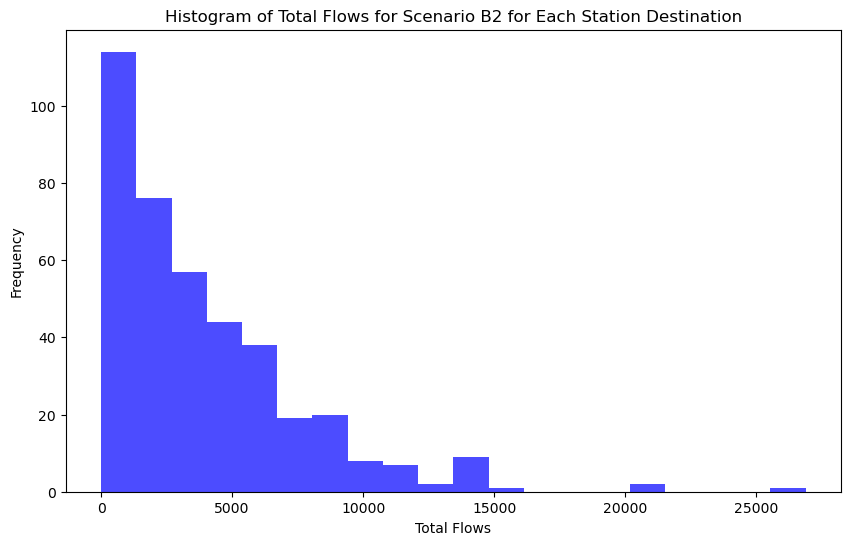

In [68]:
# Plotting the histogram
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.hist(total_beta2, bins=20, color='blue', alpha=0.7)  # Histogram with 20 bins and semi-transparent blue color

# Adding labels and title
plt.xlabel('Total Flows')
plt.ylabel('Frequency')
plt.title('Histogram of Total Flows for Scenario B2 for Each Station Destination')

plt.savefig('scenario_B2_hist.png', bbox_inches='tight')

# Show the plot
plt.show()

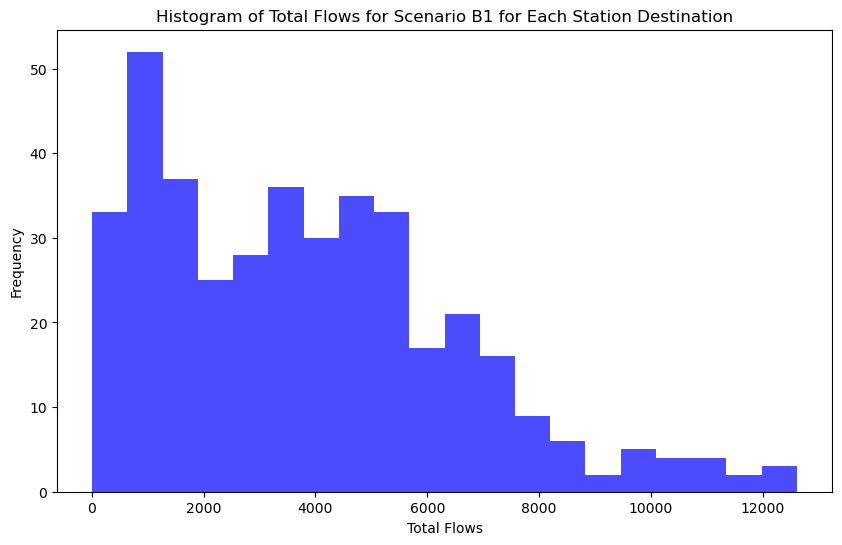

In [69]:
# Plotting the histogram
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.hist(total_beta1, bins=20, color='blue', alpha=0.7)  # Histogram with 20 bins and semi-transparent blue color

# Adding labels and title
plt.xlabel('Total Flows')
plt.ylabel('Frequency')
plt.title('Histogram of Total Flows for Scenario B1 for Each Station Destination')



plt.savefig('scenario_B1_hist.png', bbox_inches='tight')

# Show the plot
plt.show()


In [70]:
#total flows including in and out flows

compare["prodsimest4_abs"] = data_scenario_a["prodsimest4"].abs()
total_scenarioa = compare.groupby(by="station_destination")["prodsimest4_abs"].sum()

total_scenarioa_sorted = total_scenarioa.sort_values(ascending=False)

print(total_scenarioa_sorted)

station_destination
Stratford            14134.896892
Farringdon           12008.106881
Russell Square       10301.068135
Bank and Monument    10098.247654
Waterloo              9954.863558
                         ...     
Gidea Park             310.138622
Wandsworth Road        308.723111
Goodmayes              240.816962
Bushey                 238.830091
Emerson Park            11.046639
Name: prodsimest4_abs, Length: 398, dtype: float64


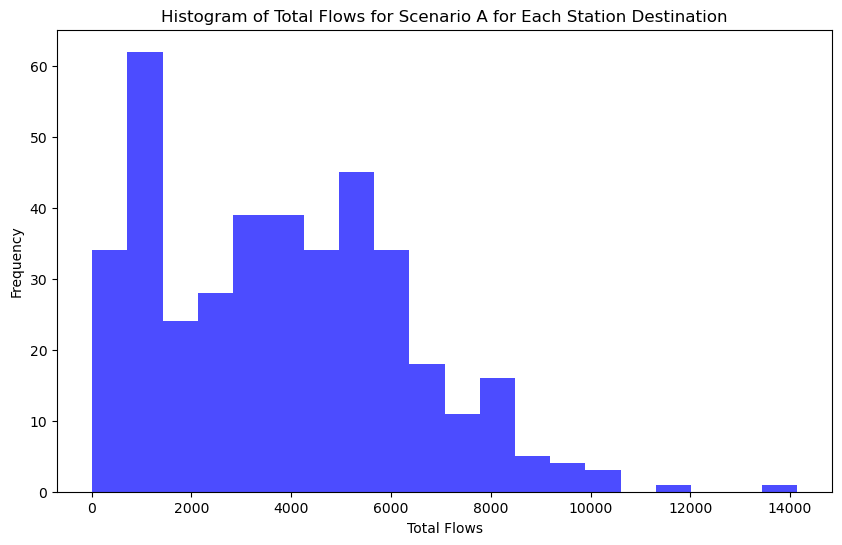

In [71]:
# Plotting the histogram
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.hist(total_scenarioa, bins=20, color='blue', alpha=0.7)  # Histogram with 20 bins and semi-transparent blue color

# Adding labels and title
plt.xlabel('Total Flows')
plt.ylabel('Frequency')
plt.title('Histogram of Total Flows for Scenario A for Each Station Destination')



plt.savefig('scenario_a_hist.png', bbox_inches='tight')

# Show the plot
plt.show()

In [72]:
#total flows including in and out flows

compare["flows_abs"] = compare["flows"].abs()
total_flows = compare.groupby(by="station_destination")["flows"].sum()

total_flows = total_flows.sort_values(ascending=False)

print(total_flows)

station_destination
Bank and Monument    78549
Liverpool Street     61122
Canary Wharf         58772
Stratford            55954
Oxford Circus        44368
                     ...  
West Finchley           91
Beckton Park            88
Roding Valley           84
Grange Hill             76
Emerson Park            42
Name: flows, Length: 398, dtype: int64


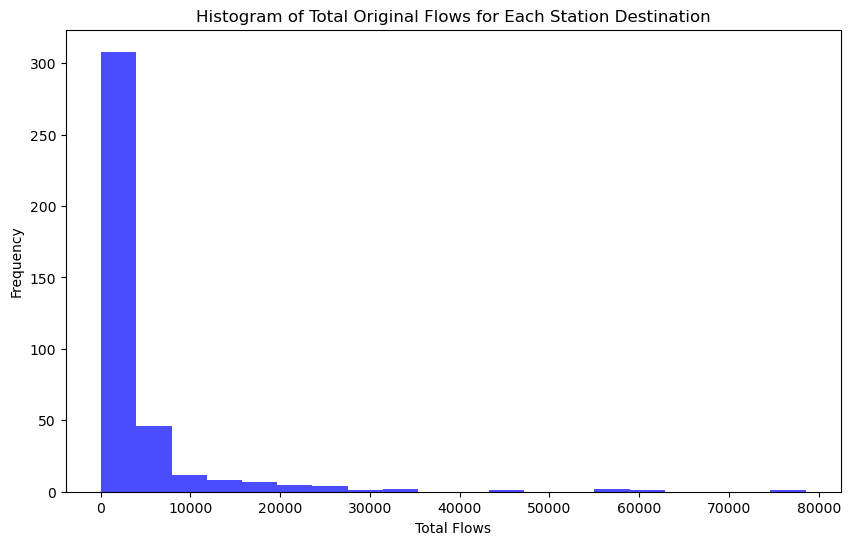

In [73]:
# Plotting the histogram
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.hist(total_flows, bins=20, color='blue', alpha=0.7)  # Histogram with 20 bins and semi-transparent blue color

# Adding labels and title
plt.xlabel('Total Flows')
plt.ylabel('Frequency')
plt.title('Histogram of Total Original Flows for Each Station Destination')

plt.savefig('scenario_a_hist.png', bbox_inches='tight')

# Show the plot
plt.show()

In [74]:
#total flows
gained_beta_2 = compare.groupby(by="station_destination")["Diff_beta2_gained"].sum()

gained_beta_2_sorted = gained_beta_2.sort_values(ascending=False)

print(gained_beta_2_sorted)

station_destination
Barking            19147.0
Upton Park         15212.0
Warren Street      11337.0
Cyprus              9396.0
West Kensington     9149.0
                    ...   
Parsons Green      -5768.0
Stratford          -6638.0
Willesden Green    -7893.0
Uxbridge          -13136.0
South Wimbledon   -15480.0
Name: Diff_beta2_gained, Length: 398, dtype: float64


In [75]:
# here negative values are flows gained and positive are flows lost
compare["Diff_beta2_lost"] = data_scenario_b["flows"]-data_scenario_b["SIM_est_exp_2"]
compare.head()

,station_origin,station_destination,flows,Oi_origpop,Dj_destjob,Dist,Diff_beta1_gained,SIM_est_exp_abs,Diff_beta1_lost,Diff_beta2_gained,SIM_est_exp_2_abs,prodsimest4_abs,flows_abs,Diff_beta2_lost
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,52.0,52.0,-52.0,23.0,23.0,83.325388,0,-23.0
1,Abbey Road,Beckton,1,599,442,8510.121774,1.0,2.0,-1.0,-1.0,0.0,1.572380,1,1.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,0.0,3.0,0.0,0.0,3.0,4.420589,3,0.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,112.0,113.0,-112.0,93.0,94.0,63.219255,1,-93.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,26.0,63.0,-26.0,107.0,144.0,60.200464,37,-107.0


In [76]:
#total flows
lost_beta_2 = compare.groupby(by="station_destination")["Diff_beta2_lost"].sum()

lost_beta_2_sorted = lost_beta_2.sort_values(ascending=False)

print(lost_beta_2_sorted)

station_destination
South Wimbledon    15480.0
Uxbridge           13136.0
Willesden Green     7893.0
Stratford           6638.0
Parsons Green       5768.0
                    ...   
West Kensington    -9149.0
Cyprus             -9396.0
Warren Street     -11337.0
Upton Park        -15212.0
Barking           -19147.0
Name: Diff_beta2_lost, Length: 398, dtype: float64


In [77]:
compare.head()

,station_origin,station_destination,flows,Oi_origpop,Dj_destjob,Dist,Diff_beta1_gained,SIM_est_exp_abs,Diff_beta1_lost,Diff_beta2_gained,SIM_est_exp_2_abs,prodsimest4_abs,flows_abs,Diff_beta2_lost
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,52.0,52.0,-52.0,23.0,23.0,83.325388,0,-23.0
1,Abbey Road,Beckton,1,599,442,8510.121774,1.0,2.0,-1.0,-1.0,0.0,1.572380,1,1.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,0.0,3.0,0.0,0.0,3.0,4.420589,3,0.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,112.0,113.0,-112.0,93.0,94.0,63.219255,1,-93.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,26.0,63.0,-26.0,107.0,144.0,60.200464,37,-107.0


In [78]:
compare['SIM_est_exp_2'] = data_scenario_b['SIM_est_exp_2']

In [79]:
compare['SIM_est_exp'] = data_scenario_b['SIM_est_exp']

In [80]:
compare.head()

,station_origin,station_destination,flows,Oi_origpop,Dj_destjob,Dist,Diff_beta1_gained,SIM_est_exp_abs,Diff_beta1_lost,Diff_beta2_gained,SIM_est_exp_2_abs,prodsimest4_abs,flows_abs,Diff_beta2_lost,SIM_est_exp_2,SIM_est_exp
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,52.0,52.0,-52.0,23.0,23.0,83.325388,0,-23.0,23.0,52.0
1,Abbey Road,Beckton,1,599,442,8510.121774,1.0,2.0,-1.0,-1.0,0.0,1.572380,1,1.0,0.0,2.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,0.0,3.0,0.0,0.0,3.0,4.420589,3,0.0,3.0,3.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,112.0,113.0,-112.0,93.0,94.0,63.219255,1,-93.0,94.0,113.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,26.0,63.0,-26.0,107.0,144.0,60.200464,37,-107.0,144.0,63.0


In [81]:
compare['SIM_est_exp_2_abs'].describe()

count    61352.000000
mean        25.118448
std        220.126241
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      15489.000000
Name: SIM_est_exp_2_abs, dtype: float64

In [82]:
compare['SIM_est_exp_abs'].describe()

count    61352.000000
mean        25.087837
std        110.364181
min          0.000000
25%          0.000000
50%          2.000000
75%         13.000000
max       5515.000000
Name: SIM_est_exp_abs, dtype: float64

In [83]:
data_scenario_a['prodsimest4'].describe()

count    61413.000000
mean        25.113298
std         80.342254
min          0.000293
25%          1.289844
50%          5.638347
75%         19.760771
max       3717.399677
Name: prodsimest4, dtype: float64

In [84]:
compare['flows_abs'].describe()

count    61413.000000
mean        25.113298
std        131.479668
min          0.000000
25%          0.000000
50%          3.000000
75%         13.000000
max      15946.000000
Name: flows_abs, dtype: float64

In [85]:
zero_count = (beta_2_abs == 0.0).sum()

print(f"Number of station destinations with a total 'SIM_est_exp_abs' of zero: {zero_count}")

NameError: name 'beta_2_abs' is not defined

In [ ]:
#total flows
beta_1_abs = compare.groupby(by="station_destination")['SIM_est_exp_abs'].sum()

beta_1_abs_sorted = beta_1_abs.sort_values(ascending=False)

print(beta_1_abs_sorted)

In [ ]:
compare.head()

In [ ]:
df_sorted = compare.sort_values(by='Diff_beta1_gained', ascending=False).head(10)

# Create the plot
plt.figure(figsize=(12, 7))  # Adjusted size for readability

# Set the bar width
width = 0.35

# Generate indices for the x-axis positions
indices = range(len(df_sorted['station_destination']))

# Bar for Diff_beta1_gained
plt.bar(indices, df_sorted['SIM_est_exp'].abs(), width, label='Scenario B1')

# Bar for Diff_beta2_gained, positioned next to the first set
plt.bar([i + width for i in indices], df_sorted['SIM_est_exp_2'].abs(), width, label='Scenario B2')

# Add labels and title
plt.xlabel('Station Destination')
plt.ylabel('Total Number of Flows')
plt.title('Total Number of Flows by Station for Scenario B1 and Scenario B2')

# Custom x-axis tick labels
plt.xticks([i + width / 2 for i in indices], df_sorted['station_destination'], rotation=45)  # Ensure labels are in the middle of grouped bars

# Add a legend
plt.legend()

# Layout adjustment and plot display
plt.tight_layout()
plt.show()

In [ ]:
df_sorted = compare.sort_values(by='Diff_beta1_lost', ascending=False).head(10)

# Create the plot
plt.figure(figsize=(12, 7))  # Adjusted size for readability

# Set the bar width
width = 0.35

# Generate indices for the x-axis positions
indices = range(len(df_sorted['station_destination']))

# Bar for Diff_beta1_gained
plt.bar(indices, df_sorted['Diff_beta1_lost'], width, label='Scenario B1')

# Bar for Diff_beta2_gained, positioned next to the first set
plt.bar([i + width for i in indices], df_sorted['Diff_beta2_lost'], width, label='Scenario B2')

# Add labels and title
plt.xlabel('Station Destination')
plt.ylabel('Number of Inflows Lost')
plt.title('Number of Lost Inflows by Station for Scenario B1 and Scenario B2')

# Custom x-axis tick labels
plt.xticks([i + width / 2 for i in indices], df_sorted['station_destination'], rotation=45)  # Ensure labels are in the middle of grouped bars

# Add a legend
plt.legend()

# Layout adjustment and plot display
plt.tight_layout()
plt.show()

In [ ]:
df_sorted = compare.sort_values(by='Diff_beta2_lost', ascending=False).head(10)

plt.figure(figsize=(14, 8))

# Adjust the bar width to accommodate three bars
width = 0.25

# Generate indices for the x-axis positions
indices = range(len(df_sorted['station_destination']))

# Bar for Diff_beta1_lost
plt.bar([i - width for i in indices], df_sorted['Diff_beta1_lost'], width, label='Diff_beta1_lost', color='blue')

# Bar for Diff_beta2_lost, positioned at the center
plt.bar(indices, df_sorted['Diff_beta2_lost'], width, label='Diff_beta2_lost', color='green')

# Bar for flows, positioned to the right of the first two
plt.bar([i + width for i in indices], df_sorted['flows'], width, label='Flows', color='red')

# Add labels and title
plt.xlabel('Station Destination')
plt.ylabel('Values')
plt.title('Comparison of Beta Losses and Flows for Top 10 Destinations by Beta2 Lost')

# Custom x-axis tick labels
plt.xticks(indices, df_sorted['station_destination'], rotation=45)  # Ensure labels are in the middle of grouped bars

# Add a legend
plt.legend()

# Layout adjustment and plot display
plt.tight_layout()
plt.show()


In [ ]:
df_sorted = compare.sort_values(by='Diff_beta2_gained', ascending=False).head(10)

plt.figure(figsize=(14, 8))

# Adjust the bar width to accommodate three bars
width = 0.25

# Generate indices for the x-axis positions
indices = range(len(df_sorted['station_destination']))

# Bar for Diff_beta1_lost
plt.bar([i - width for i in indices], df_sorted['Diff_beta1_gained'], width, label='Diff_beta1_gained', color='blue')

# Bar for Diff_beta2_lost, positioned at the center
plt.bar(indices, df_sorted['Diff_beta2_gained'], width, label='Diff_beta2_gained', color='green')

# Bar for flows, positioned to the right of the first two
plt.bar([i + width for i in indices], df_sorted['flows'], width, label='Flows', color='red')

# Add labels and title
plt.xlabel('Station Destination')
plt.ylabel('Values')
plt.title('Comparison of Beta Losses and Flows for Top 10 Destinations by Beta2 Lost')

# Custom x-axis tick labels
plt.xticks(indices, df_sorted['station_destination'], rotation=45)  # Ensure labels are in the middle of grouped bars

# Add a legend
plt.legend()

# Layout adjustment and plot display
plt.tight_layout()
plt.show()

In [ ]:
# Create the histogram plot
plt.figure(figsize=(10, 6))

# Plot histograms
plt.hist(total_scenarioa, bins=20, alpha=0.5, label='Scenario A')
plt.hist(total_beta1, bins=20, alpha=0.5, label='Scenario B1')
plt.hist(total_beta2, bins=20, alpha=0.5, label='Scenario B2')
plt.hist(total_flows, bins=20, alpha=0.5, label='Original Flows')

# Adding labels and title
plt.xlabel('Flows')
plt.ylabel('Frequency')
plt.title('Comparison of the Distribution of Flows for Station Destinations Under Different Scenarios')

# Add legend
plt.legend()

plt.savefig('all_hist.png', bbox_inches='tight')

# Show the plot
plt.show()